# Eigen faces

This is an attemp of solving the PCA with faces problem presented on MIT edX course on Data Science and Big Data. The approach taken here resembles the enunciate in that we tried to use only low level packages for linear algebra instead of off-the-shelf PCA libraries. Please send any feedback to [Raphael Fanti](mailto:raphael.fanti@gmail.com).

It is worth mentioning that using other modules for PCA would resume this exercise to a few lines. The idea here was to review eigenvalues and vectors at the low, matrix level.

## Data loading and normalization

We start by loading the images from file (all on folder "data"). All images are named in a simple notation for simplicity (1.jpg, 2.jpg, ..., 14.jpg)

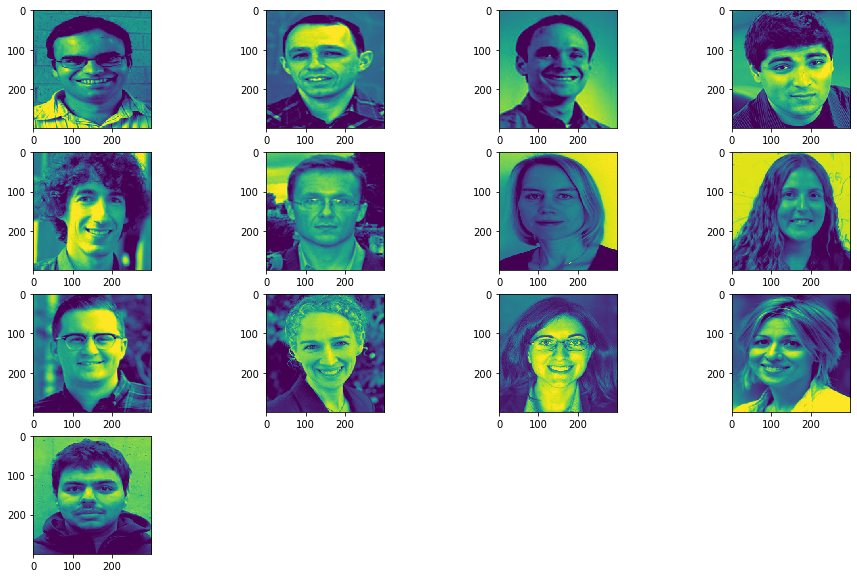

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# creation of plot figure
fig = plt.figure(figsize=(16, 10))

images = []

# number of pictures
num_images = 14
rows = 4 # for visualisation
columns = 4 # for visualisation

for i in range(1, num_images):
    img = Image.open("data/" + str(i) + ".jpg")
    images.append(img)
    fig.add_subplot(rows, columns, i)
    plt.imshow((img))

plt.show()

Next we convert the images to greyscale and compute average and standard deviation of intensity of pixels for normalization

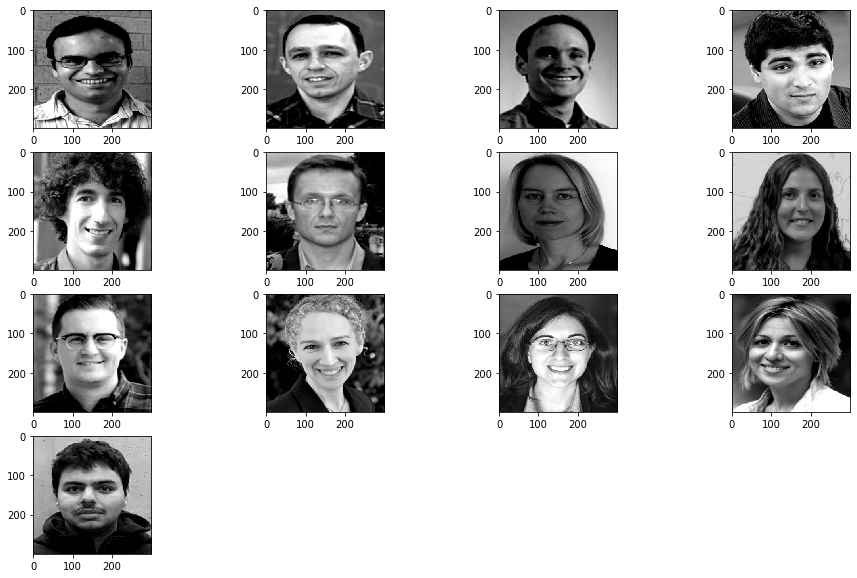

[180.72152222222223, 179.35861666666668, 180.17960555555555, 178.5049, 177.91631666666666, 179.41940555555556, 178.9010888888889, 178.17315555555555, 178.80348333333333, 178.1430222222222, 177.44803333333334, 176.38662222222223, 178.23167777777778]
[87.36977760653953, 91.1674129139339, 90.02004284639415, 93.783907754837, 94.2185220195274, 91.92888129226114, 93.07614800636739, 94.6427438401805, 92.86657201526494, 94.68823322520394, 95.90147930453882, 93.71187456437096, 94.53211431317081]


In [4]:
means = []
stds = []

fig = plt.figure(figsize=(16, 10))

for i, img in enumerate(images):
    #conversion to greyscale
    img = img.convert("LA")
    
    #transform image into array
    img = np.array(img)
    
    #get data for normalization
    means.append(np.mean(img))
    stds.append(np.std(img))
    
    #for display
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(Image.fromarray(img))

plt.show()
print(means)
print(stds)

We then proceed to normalizing the images according to formula on exercise's instruction

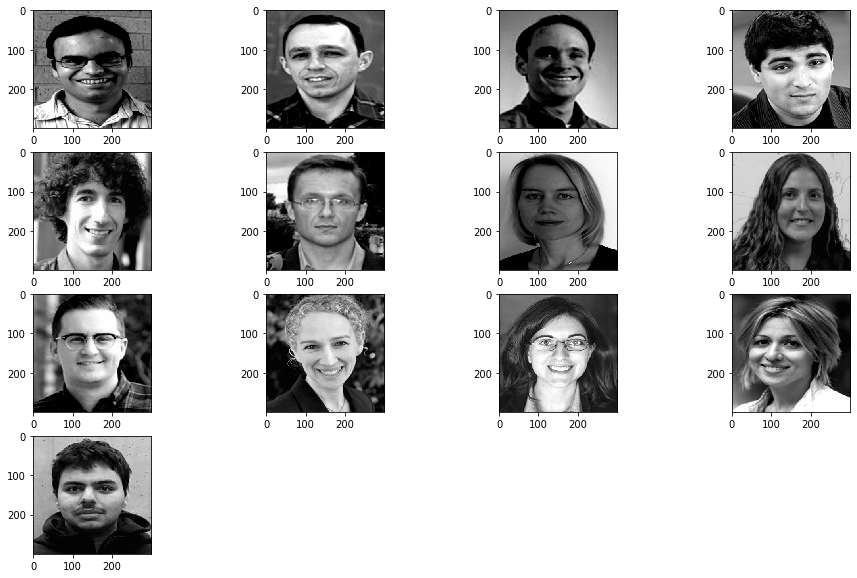

In [5]:
fig = plt.figure(figsize=(16, 10))

mean_set = np.mean(means)
std_set = np.mean(stds)

for i, img in enumerate(images):
    
    img = (img - means[i]) * std_set / stds[i] + mean_set
    
    #for display
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(Image.fromarray(img))

plt.show()

Finally we organize the normalized images info into a matrix. 


In [6]:
images_mtx = []

for i, img in enumerate(images):
    flat_img = np.matrix.flatten(np.array(img))
    images_mtx.append(flat_img)

images_mtx = np.array(images_mtx)
images_mtx = np.transpose(images_mtx)

print(images_mtx.shape)  

(90000, 13)


# Mean face

Let's get the mean face by averaging the matrix's columns

(90000,)


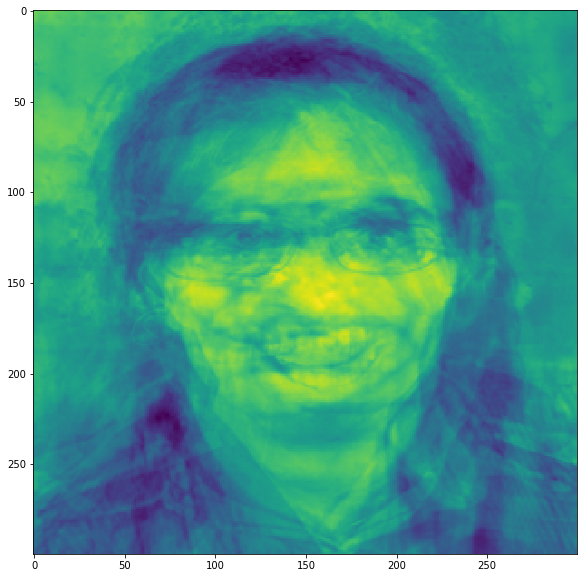

In [7]:
mean_face = np.mean(images_mtx, axis=1)
print (mean_face.shape)


# for plotting, we reshape the image in its original size
mean_face_disp = np.reshape(mean_face, [300, 300])


fig = plt.figure(figsize=(16, 10))
plt.imshow(mean_face_disp)
plt.show()

# Eigenfaces and eigenvalues with normal linear algebra (as proposed)

From the amazing article by [Liton Chandra Paul](http://ijarcet.org/wp-content/uploads/IJARCET-VOL-1-ISSUE-9-135-139.pdf)

It is easy to understand that the eigenvector solution for such a large dimension is not smart. In fact, code in numpy to transpose and multiply matrices to find covariance (L matrix) did not work. We solve for the lighter L matrix, which shares the same eigenvalues with the original covariance matrix C

We start by removing the average out of each face image

mean: [141.15384615 140.69230769 139.84615385 ...  78.61538462  75.46153846
  72.07692308]
Before and after difference: [141.15384615 140.69230769 139.84615385 ...  78.61538462  75.46153846
  72.07692308]


<Figure size 1152x720 with 0 Axes>

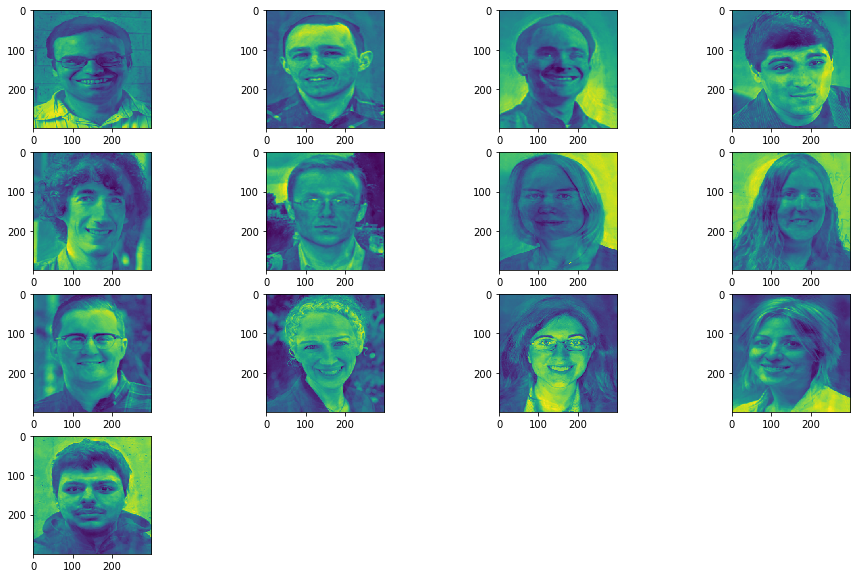

In [9]:
fig = plt.figure(figsize=(16, 10))

# remove mean_face from all columns without iterating
images_less_avg_transposed = images_mtx.T -  mean_face
images_less_avg = images_less_avg_transposed.T

#testing values for 1st image
print("mean:", mean_face)
print("Before and after difference:", images_mtx[:,0] - images_less_avg[:,0] )

#plotting difference in faces
fig = plt.figure(figsize=(16, 10))
for i in range(images_less_avg.shape[1]):
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(np.reshape(images_less_avg[:, i], [300, 300]))

plt.show()

We proceed to calculate the eigenvalues and vectors of matrix L = At*A, who condivides eigenvalues with the actual covariance matrix C = A*At. This is a pretty cool trick that avoids having to calculate the entire images matrixes eigenvalues and vectors, only a 14 x 14 matrix one. The [Liton Chandra Paul](http://ijarcet.org/wp-content/uploads/IJARCET-VOL-1-ISSUE-9-135-139.pdf) article notes that these 13 values and vectors found share the largest ones with the (much) larger matrix

(13, 13)
(90000, 13)


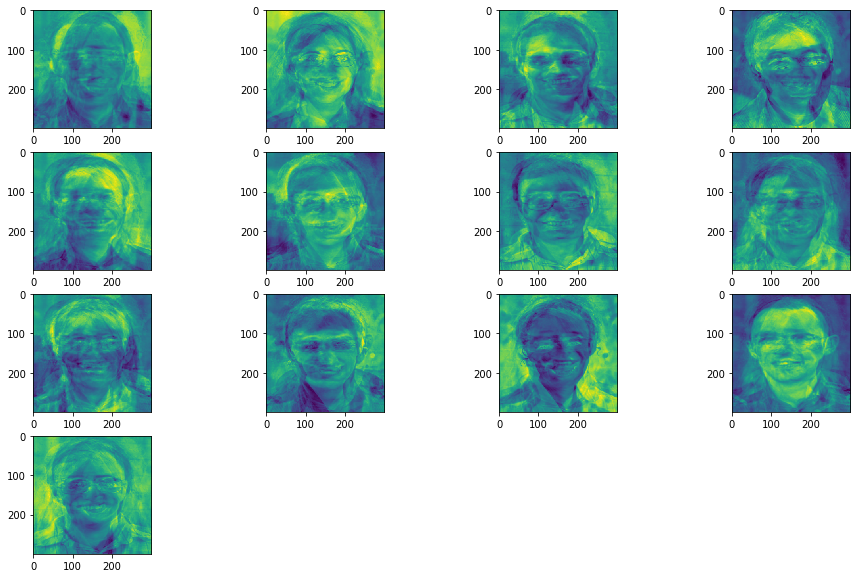

In [10]:
# L is found multiplying Transposed(A) and A
L = images_less_avg.T.dot(images_less_avg)

# eigenvalues and eigenvectors
eigvalues, eigvectors_L = np.linalg.eig(L)

print(eigvectors_L.shape)

# transform eigenvectors for L into vectors for C
eigvectors_transposed = []
for i in range(eigvectors_L.shape[1]):
    eigvectors_transposed.append(np.matmul(images_less_avg, eigvectors_L[i]))

eigvectors_transposed = np.array(eigvectors_transposed)
eigvectors = eigvectors_transposed.T


print(eigvectors.shape)

#print the n eigenfaces
fig = plt.figure(figsize=(16, 10))
for i in range(eigvectors.shape[1]):
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(np.reshape(eigvectors[:,i], [300, 300]))

plt.show()


# Reconstructing faces using N eigenvalues

What follows continues the python implementation of the above mentioned article. Weights are calculated as the projection of a given image (always working without average) into the set of eigenvectors, the amount n of vectors chosen influences the quality of reconstructed images, it works as a "compression rate".

The mean has to be re-included back to each image.

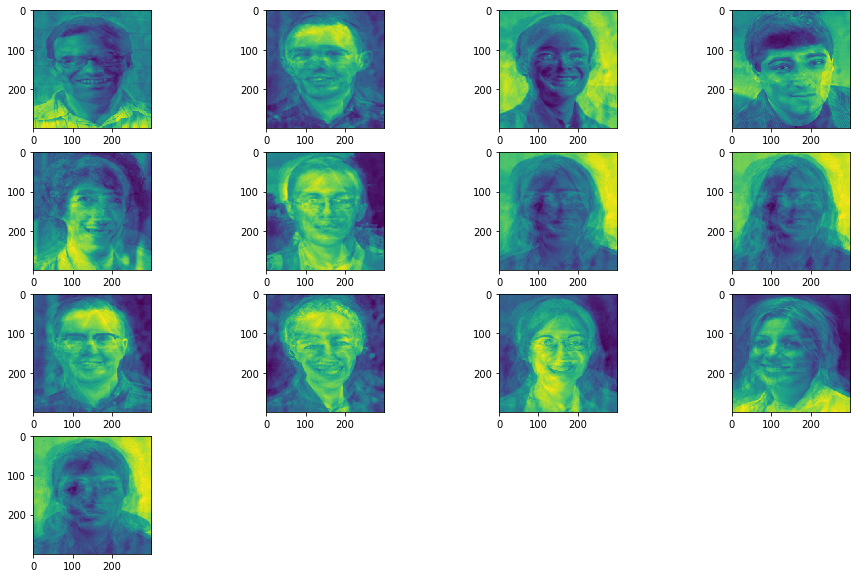

In [20]:
# amount of eigenvalues to keep (max 13)
n = 13

# selection of correspondent highest eigenvalues and vectors
eigvalues_sel = eigvalues[:n]
eigvectors_sel = eigvectors[:, :n]

reconstructed_faces = []
for face in range(len(images)):
    
    # calculate weights vector
    w = []
    for i in range(n):
        w.append(eigvectors_sel[:, i].T.dot((images_less_avg[:, face])))

    #print(w)

    # now reconstructing the face
    
    face_eigen = 0 * eigvectors[:,0]

    for i in range(n):
        face_eigen += w[i]*eigvectors[:,i]

    face_reconstructed = mean_face + face_eigen
    
    reconstructed_faces.append(face_reconstructed)


# printing 

fig = plt.figure(figsize=(16, 10))
for i, face in enumerate(reconstructed_faces):
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(np.reshape(face, [300, 300]))
    
plt.show()
